In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('/home/jshe/prop-pred/src/data')
from data_utils.datasets import SmilesDataset
from data_utils.graphs import smiles_to_graphs

#from gat import G

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader

from sklearn.metrics import r2_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%load_ext autoreload
%autoreload 2

In [163]:
B, L, E = 32, 9, 64
H = 4
A = E // 4

e_l = torch.randn(B, H, L, A)
e_r = torch.randn(B, H, L, A)
adj = torch.randn(B, 1, L, L) > 0

attn_map = nn.Linear(A, 1)

In [164]:
attn = e_l.unsqueeze(2) + e_r.unsqueeze(3)
attn = attn_map(attn).squeeze(-1)
attn.masked_fill_(~adj.unsqueeze(1), torch.finfo(attn.dtype).min)
attn = torch.softmax(attn, dim=-1)

values = attn @ e_r
values = values.permute(0, 2, 1, 3)
values = values.reshape(B, L, E)

In [165]:
g_l, g_r = e_l[0].permute(1, 0, 2), e_r[0].permute(1, 0, 2)

g_l_repeat = g_l.repeat(L, 1, 1)
g_r_repeat_interleave = g_r.repeat_interleave(L, dim=0)
g_sum = g_l_repeat + g_r_repeat_interleave

g_sum = g_sum.view(L, L, H, A)

e = attn_map(g_sum).squeeze(-1)
e_masked = e.masked_fill(~adj[0].reshape(L, L, 1), torch.finfo(e.dtype).min)

a = torch.softmax(e_masked, dim=1)

attn_res = torch.einsum('ijh,jhf->ihf', a, g_r)
attn_res = attn_res.reshape(L, E)

## Data

In [2]:
dataset = SmilesDataset(
    smiles='/home/jshe/prop-pred/src/data/qm9/smiles.csv', 
    y='/home/jshe/prop-pred/src/data/qm9/norm_y.csv', 
    d = '/home/jshe/prop-pred/src/data/qm9/distances.npy'
)

train_dataset, validation_dataset, test_dataset = random_split(
    dataset, lengths=(0.8, 0.1, 0.1), 
    generator=torch.Generator().manual_seed(8)
)

In [3]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=2048, shuffle=True)

## Model

In [25]:
hyperparameters = dict(
    numerical_features=5, categorical_features=(9+1, 8+1, 2+1, 2+1), 
    E=64, H=4, stack='G', 
    dropout=0.1, 
    out_features=dataset.n_properties, 
)

model = GraphTransformer(**hyperparameters).to(device)
model.eval()

print(sum(p.numel() for p in model.parameters()))

52751


## Visualization

In [15]:
logs = [
    './logs/gat.csv', 
]

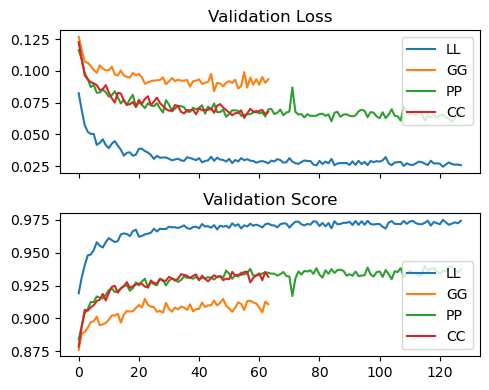

In [16]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(5, 4), sharex=True)

for i, log in enumerate(logs):
    log = pd.read_csv(log)

    ax0.plot(log['validation_mse'], label=logs[i][7:9])
    ax1.plot(log['validation_r2'], label=logs[i][7:9])

ax0.set_title('Validation Loss')
ax1.set_title('Validation Score')

ax0.legend()
ax1.legend()

plt.tight_layout()